In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import pynumdiff
import scipy.fftpack
from IPython.display import display,SVG
import figurefirst
fifi = figurefirst

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
import run_pareto_plot

In [3]:
def get_gamma(dt, freq, timeseries_length=None):
    try:
        if dt == 0.1:
            log_g = np.log(freq)*(-1.5) -4
        if dt == 0.01:
            log_g = np.log(freq)*(-1.5) -1.8
        if dt == 0.001:
            log_g = np.log(freq)*(-1.5) -1.2
            
        return np.exp(log_g)
    
    except:
        log_gs = []
        for f in freq:
            if dt == 0.1:
                log_gs.append(np.log(freq)*(-1.5) -4) 
            if dt == 0.01:
                log_gs.append(np.log(freq)*(-1.5) -1.8) 
            if dt == 0.001:
                log_gs.append(np.log(freq)*(-1.5) -1.2) 
            
        return np.exp(np.array(log_gs))
            


In [4]:
def plot_power_spectra(x, t, cutoff_freq=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_yscale('log')
    ax.set_xscale('log')
        
    yf = scipy.fftpack.fft(x)
    N = len(t)
    dt = np.mean(np.diff(t))
    xf = np.linspace(0.0, 1.0/(2.0*dt), N/2)
    
    P = 2.0/N * np.abs(yf[:N//2])
    ax.plot(xf, P, color='black', zorder=-10)
    
    if cutoff_freq is not None:
        ax.vlines(cutoff_freq, 1e-3, 1e1, color='red')

In [5]:
def make_plot(method, method_parent, problem, dt, noise, timeseries_length, cutoff_freq, 
              ax_data=None, ax_pos=None, ax_vel=None, ax_spectra=None, color=None):
    if color is None:
        color = 'red'
    
    # simulate
    print('simulating')
    if problem == 'pi_control':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, simdt=0.01)
    elif problem != 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
    elif problem == 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, frequencies=[7, 10])
        
    x, x_truth, dxdt_truth, _ = r
    t = np.linspace(0, timeseries_length, len(x))
    print('done simulating')
    
    # optimize params
    tvgamma = get_gamma(dt, cutoff_freq)
    #if method == 'jerk':
    #    if dt < 0.005:
    #        tvgamma = tvgamma * 100
    print('tvgamma: ', tvgamma)
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma)
    print('optimizer params: ', params)
    
    # estimate derivative
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    
    # plot data
    #ax_data.plot(t, x, color='blue', zorder=1)
    if ax_data is not None:
        ax_data.plot(t, x, '.', color='blue', zorder=-10, markersize=2)
        ax_data.set_rasterization_zorder(0)
        ax_data.set_xlim(0, timeseries_length)
        
    # plot vel
    if ax_vel is not None:
        ax_vel.plot(t, xdot_smooth, color=color)
        ax_vel.plot(t, dxdt_truth, '--', color='black')
        ax_vel.set_xlim(0, timeseries_length)
    
    # plot pos
    if ax_pos is not None:
        ax_pos.plot(t, x_smooth, color=color)
        ax_pos.plot(t, x_truth, '--', color='black')
        ax_pos.set_xlim(0, timeseries_length)
    
    
    
    if ax_spectra is not None:
        plot_power_spectra(x, t, cutoff_freq, ax_spectra)
    

In [6]:
def load_data(fname):
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [7]:
def plot_rmse_errcorr(data, ax=None, plot=True, color=None, plot_gray=True):
    if color is None:
        color = 'violet'
    if ax is None:
        if plot:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
        
    keys = ['rmses', 'errcorrs', 'rmses_gamma', 'errcorrs_gamma']
    for key in keys:
        data[key][np.where(data[key]==None)] = np.nan
        data[key] = data[key].astype(float)
    
    print('n data pts: ', len(data['rmses']))
    #idx, opt_logrmse, opt_errcorr = find_elbow(np.log(data['rmses_gamma']), data['errcorrs_gamma'])
    #opt_gamma = data['metadata']['gammas'][idx]
    
    if plot_gray:
        ax.plot((data['rmses']), data['errcorrs'], '.', color='gray', zorder=-10, markersize=2)
        
    if plot:
        
        ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '-', color=color)
        ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '.', color=color)
        #ax.plot(np.exp(opt_logrmse), opt_errcorr, '*', color='red', markersize=20)
        #ax.set_xlim(0, 5)
        ax.set_ylim(0, 1)
            
    #return opt_gamma

In [8]:
def plot_goldilocks_gamma(dt, cutoff_freq, x, x_truth, dxdt_truth, ax, method, method_parent, color=None):
    if color is None:
        color = 'red'
    tvgamma = get_gamma(dt, cutoff_freq)

    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma)
    print(params)

    rmse, errcorr = run_pareto_plot.get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    
    print('goldilocks rmse and errcorr: ', rmse, errcorr)
    ax.plot(rmse, errcorr, '*', color=color, markersize=20, markeredgecolor='black')
    
    #ax.set_xlim(1e-1, 1e2)

In [9]:
def prep_spines(layout, example, xlimits, ylimits, xticks, yticks):
    for ax_label, xlim in xlimits.items():
        try:
            ax = layout.axes[(example, ax_label)]
        except:
            continue
            
        ylim = ylimits[ax_label]
        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if ax_label == 'spectra':
            ax.set_yscale('log')
            ax.set_xscale('log')
            print(xticks[ax_label])
            print(yticks[ax_label])
            ax.minorticks_off()
        if ax_label == 'pareto':
            ax.set_xscale('log')
            ax.minorticks_off()
        
        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if 1:
            fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                             xticks=xticks[ax_label], 
                                             yticks=yticks[ax_label],
                                             tick_length=2.5,
                                             spine_locations={'left': 4, 'bottom': 4})

        ax.set_xlim(xlim[0], xlim[-1])
        ax.set_ylim(ylim[0], ylim[-1])
        
        if 1:
            fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                             xticks=xticks[ax_label], 
                                             yticks=yticks[ax_label],
                                             tick_length=2.5,
                                             spine_locations={'left': 4, 'bottom': 4})
            
        if ax_label == 'spectra' and example == 'example_1':
            xtl = ['$10^{' + str(int(np.log10(xticks['spectra'][0]))) + '}$',
                   '',
                   '',
                   '',
                   '$10^{' + str(int(np.log10(xticks['spectra'][-1]))) + '}$']
            ax.set_xticklabels(xtl)
            
            ytl = ['$10^{' + str(int(np.log10(yticks['spectra'][0]))) + '}$',
                   '',
                   '',
                   '',
                   '$10^{' + str(int(np.log10(yticks['spectra'][-1]))) + '}$']
            ax.set_yticklabels(ytl)
            
        elif ax_label == 'spectra':
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        
    fifi.mpl_functions.set_fontsize(ax, 6)

In [10]:
def go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
       xlimits, ylimits, xticks, yticks, read_existing=True, plot_gray=True):
    # simulate
    print('simulating')
    if problem == 'pi_control':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, simdt=0.01)
        simdt = 0.01
    elif problem != 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
        simdt = 0.0001
    elif problem == 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, frequencies=[7, 10])
        simdt = 0.0001
        
    x, x_truth, dxdt_truth, _ = r
    print('done simulating')
    
    # run_pareto_analysis
    if problem == 'sine':
        fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, frequencies=[7,10], read_existing=read_existing)
    else:
        fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, read_existing=read_existing)
    
    # get axes
    print('EXAMPLE: ', example)
    layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                           make_mplfigures=True, hide_layers=[])
    ax_data = None #layout.axes[(example, 'data')]
    ax_pos = layout.axes[(example, 'pos')]
    ax_vel = layout.axes[(example, 'vel')]
    ax_spectra = None #layout.axes[(example, 'spectra')]
    ax_pareto = layout.axes[(example, 'pareto')]
    
    colors = ['violet',
              'lightgreen',
              'cornflowerblue',
              'lightsalmon']
    
    if method == 'savgoldiff':
        color = colors[0]
    if method == 'butterdiff':
        color = colors[1]
    if method == 'constant_acceleration':
        color = colors[2]
    if method == 'jerk':
        color = colors[3]

    # make pos, vel, spectra plots
    make_plot(method, method_parent, problem, dt, noise, timeseries_length, cutoff_freq, 
                  ax_data=ax_data, ax_pos=ax_pos, ax_vel=ax_vel, ax_spectra=ax_spectra, color=color)

    # make pareto plot
    data = load_data(fname)
    ax_pareto.set_xscale("log")
    plot_rmse_errcorr(data, ax=ax_pareto, plot=True, color=color, plot_gray=plot_gray)
    ax_pareto.set_rasterization_zorder(0)
    plot_goldilocks_gamma(dt, cutoff_freq, x, x_truth, dxdt_truth, ax_pareto, method, method_parent, color=color)
    
    
    # prep spines
    prep_spines(layout, example, xlimits, ylimits, xticks, yticks)
    
    
    # save
    layout.append_figure_to_layer(layout.figures[example], example, cleartarget=True)
    layout.write_svg(figure_layout)

In [11]:
figure_layout = 'fig_4_v2.svg'

In [12]:
read_existing = True

simulating
done simulating
pareto_data/pareto_data_savgoldiff_linear_model_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_savgoldiff_linear_model_lorenz_x_0.5_0.01_4_auto.pickle
EXAMPLE:  example_1
simulating
done simulating
tvgamma:  0.05844198239204049


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

optimizer params:  [9, 48, 30]
n data pts:  5481


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[9, 48, 30]
goldilocks rmse and errcorr:  1.9539376258676746 0.34510733510964026


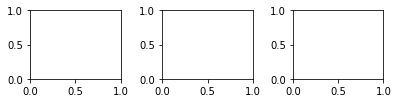

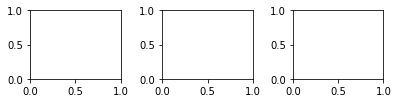

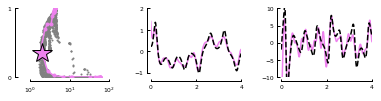

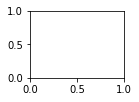

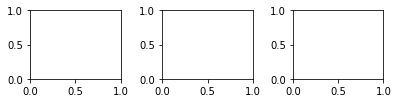

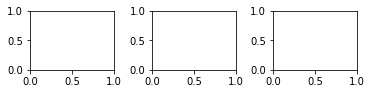

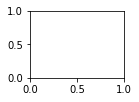

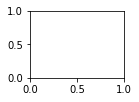

In [13]:
# define problem
example = 'example_1'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define method
method_parent = 'linear_model'
method = 'savgoldiff'

# define limits
xlimits = {#'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           #'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {#'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           #'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {#'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           #'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {#'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           #'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_butterdiff_smooth_finite_difference_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_butterdiff_smooth_finite_difference_lorenz_x_0.5_0.01_4_auto.pickle
EXAMPLE:  example_2
simulating
done simulating
tvgamma:  0.05844198239204049


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

optimizer params:  [2, 0.06941406250000004]
n data pts:  5000


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[2, 0.06941406250000004]
goldilocks rmse and errcorr:  1.9045498175896676 0.2879043690929354


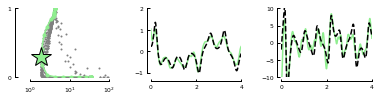

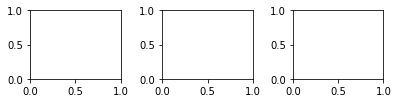

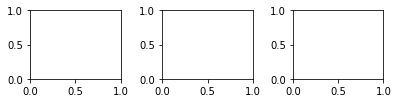

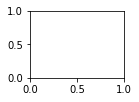

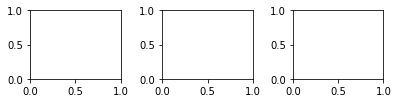

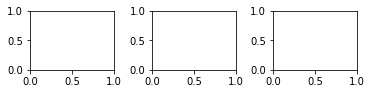

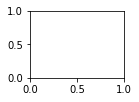

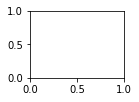

In [14]:
# define problem
example = 'example_2'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define method
method_parent = 'smooth_finite_difference'
method = 'butterdiff'

# define limits
xlimits = {#'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           #'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {#'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           #'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {#'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           #'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {#'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           #'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
EXAMPLE:  example_3
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [0.0001678124999999998, 1.875]
n data pts:  5625
[0.0001678124999999998, 1.875]
goldilocks rmse and errcorr:  1.8636200332579653 0.1847723339873928


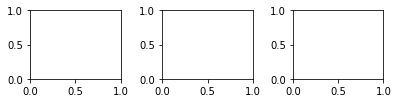

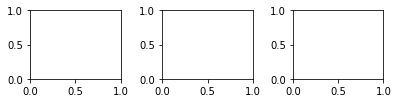

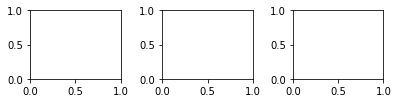

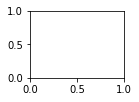

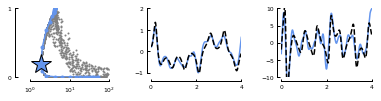

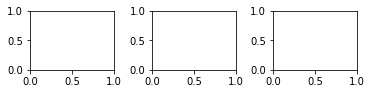

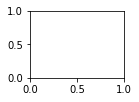

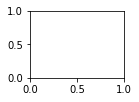

In [15]:
# define problem
example = 'example_3'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define method
method_parent = 'kalman_smooth'
method = 'constant_acceleration'

# define limits
xlimits = {#'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           #'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {#'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           #'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {#'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           #'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {#'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           #'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

simulating
done simulating
pareto_data/pareto_data_jerk_total_variation_regularization_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_jerk_total_variation_regularization_lorenz_x_0.5_0.01_4_auto.pickle
EXAMPLE:  example_4
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [192.5]
n data pts:  500
[192.5]
goldilocks rmse and errcorr:  1.804413344026917 0.0959096756548356


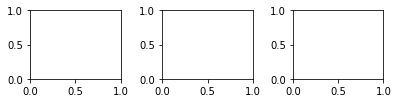

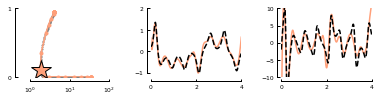

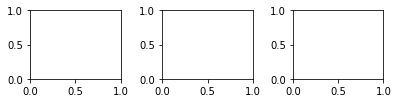

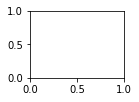

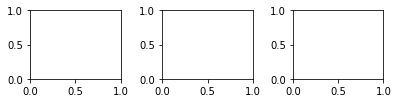

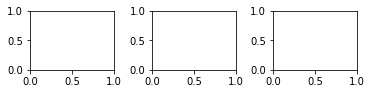

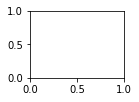

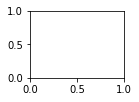

In [16]:
# define problem
example = 'example_4'
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'


# define method
method_parent = 'total_variation_regularization'
method = 'jerk'

# define limits
xlimits = {#'data': [0,4],
           'pos': [0,4],
           'vel': [0,4],
           #'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {#'data': [-1.2,2],
           'pos': [-1.2,2],
           'vel': [-10, 10],
           #'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {#'data': [0,2,4],
           'pos': [0,2,4],
           'vel': [0,2,4],
           #'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {#'data': [-1, 0, 1, 2],
           'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           #'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)

# data

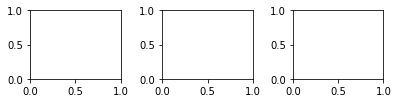

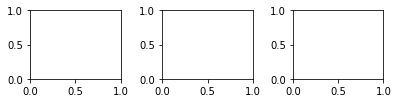

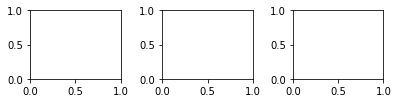

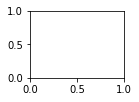

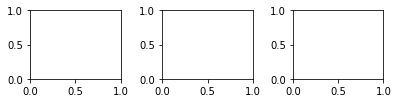

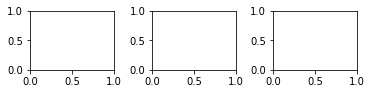

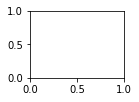

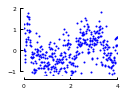

In [17]:
layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax_data = layout.axes[('data', 'data')]

r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
x, x_truth, dxdt_truth, _ = r
t = np.linspace(0, timeseries_length, len(x))

ax_data.plot(t, x, '.', color='blue', zorder=-10, markersize=2)
ax_data.set_rasterization_zorder(0)
ax_data.set_xlim(0, timeseries_length)

xlimits = {'data': [0,4]}
ylimits = {'data': [-1.2,2]}

xticks = {'data': [0,2,4]}
yticks = {'data': [-1, 0, 1, 2]}

prep_spines(layout, 'data', xlimits, ylimits, xticks, yticks)

layout.append_figure_to_layer(layout.figures['data'], 'data', cleartarget=True)
layout.write_svg(figure_layout)

In [18]:
def go_overlay(example, dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
       xlimits, ylimits, xticks, yticks, read_existing=True):
    # simulate
    print('simulating')
    if problem == 'pi_control':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, simdt=0.01)
        simdt = 0.01
    elif problem != 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt)
        simdt = 0.0001
    elif problem == 'sine':
        r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], 
                                                               dt=dt, frequencies=[7, 10])
        simdt = 0.0001
        
    x, x_truth, dxdt_truth, _ = r
    print('done simulating')
    
    # get axes
    print('EXAMPLE: ', example)
    layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                           make_mplfigures=True, hide_layers=[])

    method_parent_pairs = [['linear_model', 'savgoldiff'],
                           ['smooth_finite_difference', 'butterdiff'],
                           ['kalman_smooth', 'constant_acceleration'],
                           ['total_variation_regularization', 'jerk']]
    
    colors = ['violet',
              'lightgreen',
              'cornflowerblue',
              'lightsalmon']
    
    for i, mpp in enumerate(method_parent_pairs):
        method_parent, method = mpp
        color = colors[i]
        
        # run_pareto_analysis
        if problem == 'sine':
            fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, frequencies=[7,10], read_existing=read_existing)
        else:
            fname = run_pareto_plot.run_pareto_analysis_on_specific(noise, dt, timeseries_length, problem, method, method_parent, simdt=simdt, read_existing=read_existing)
        
        ax_vel = layout.axes[('vel', 'vel')]
        ax_pareto = layout.axes[('pareto', 'pareto')]

        # make pos, vel, spectra plots
        make_plot(method, method_parent, problem, dt, noise, timeseries_length, cutoff_freq, 
                      ax_data=None, ax_pos=None, ax_vel=ax_vel, ax_spectra=None, color=color)

        # make pareto plot
        data = load_data(fname)
        ax_pareto.set_xscale("log")
        plot_rmse_errcorr(data, ax=ax_pareto, plot=True, color=color, plot_gray=False)
        ax_pareto.set_rasterization_zorder(0)
        plot_goldilocks_gamma(dt, cutoff_freq, x, x_truth, dxdt_truth, ax_pareto, method, method_parent, color=color)

    
    # prep spines
    prep_spines(layout, 'vel', xlimits, ylimits, xticks, yticks)
    prep_spines(layout, 'pareto', xlimits, ylimits, xticks, yticks)
    
    
    # save
    layout.append_figure_to_layer(layout.figures['vel'], 'vel', cleartarget=True)
    layout.append_figure_to_layer(layout.figures['pareto'], 'pareto', cleartarget=True)
    layout.write_svg(figure_layout)

# overlay vel, pareto

simulating
done simulating
EXAMPLE:  none
pareto_data/pareto_data_savgoldiff_linear_model_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_savgoldiff_linear_model_lorenz_x_0.5_0.01_4_auto.pickle
simulating
done simulating
tvgamma:  0.05844198239204049


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

optimizer params:  [9, 48, 30]
n data pts:  5481


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[9, 48, 30]
goldilocks rmse and errcorr:  1.9539376258676746 0.34510733510964026
pareto_data/pareto_data_butterdiff_smooth_finite_difference_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_butterdiff_smooth_finite_difference_lorenz_x_0.5_0.01_4_auto.pickle
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [2, 0.06941406250000004]
n data pts:  5000
[2, 0.06941406250000004]
goldilocks rmse and errcorr:  1.9045498175896676 0.2879043690929354
pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
found file:  pareto_data/pareto_data_constant_acceleration_kalman_smooth_lorenz_x_0.5_0.01_4_auto.pickle
simulating
done simulating
tvgamma:  0.05844198239204049
optimizer params:  [0.0001678124999999998, 1.875]
n data pts:  5625
[0.0001678124999999998, 1.875]
goldilocks rmse and errcorr:  1.8636200332579653 0.1847723339873928
pareto_data/pareto_data_jerk_total_variation_regularization_lorenz_x_0.5_0.01_4_auto.pick

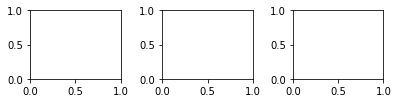

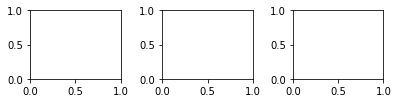

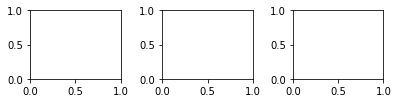

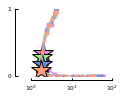

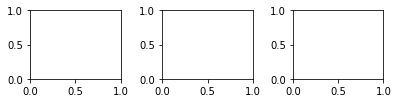

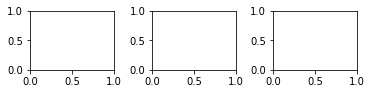

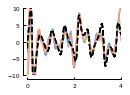

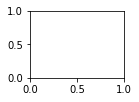

In [19]:
r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], dt=dt)
x, x_truth, dxdt_truth, _ = r
t = np.linspace(0, timeseries_length, len(x))

# define problem
dt = 0.01
noise = 0.5
timeseries_length = 4
cutoff_freq = 2
problem = 'lorenz_x'

# define limits
xlimits = {#'data': [0,4],
           #'pos': [0,4],
           'vel': [0,4],
           #'spectra': [1e-2,1e2],
           'pareto': [5e-1, 1e2]}
ylimits = {#'data': [-1.2,2],
           #'pos': [-1.2,2],
           'vel': [-10, 10],
           #'spectra': [1e-3,1e1],
           'pareto': [0, 1]}

xticks = {#'data': [0,2,4],
           #'pos': [0,2,4],
           'vel': [0,2,4],
           #'spectra': [1e-2, 1e-1, 1e0, 1e1, 1e2],
           'pareto': [1e0, 1e1, 1e2]}
yticks = {#'data': [-1, 0, 1, 2],
           #'pos': [-1, 0, 1, 2],
           'vel': [-10, -5, 0, 5, 10],
           #'spectra': [1e-3,1e-2, 1e-1, 1e0, 1e1],
           'pareto': [0, 1]}

go_overlay('none', dt, noise, timeseries_length, cutoff_freq, problem, method_parent, method, 
   xlimits, ylimits, xticks, yticks, read_existing=read_existing)